In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.cluster import KMeans #K-Means Clustering

In [4]:
#set file path to working directory and data
base_fp = 'C:\\Users\\steve\\Google Drive\\Job\\di_challenge\\food_stores\\data2\\'
os.chdir(base_fp)

# read json file
# Opening JSON file
f_train = open('train_data.json')
f_test = open('test_data.json',)

# returns JSON object as
# a dictionary
data_train = json.load(f_train)
data_test = json.load(f_test)

# Closing file
f_train.close()
f_test.close()

In [5]:
#convert data to data frame
df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)
df_train.cuisine = df_train.cuisine.astype('category')

In [6]:
### NLT
d = {'cus': df_train.cuisine.unique(), 'ingr':' '}
df_cus = pd.DataFrame(d)
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
for cc in df_cus.cus.unique():
    print(cc)
    recipes = df_train.loc[df_train.cuisine==cc].ingredients
    all_ingr = ''
    for idn in recipes:
        for ii in idn:
            ww = word_tokenize(ii)
            fww = [word.lower() for word in ww if word.casefold() not in stop_words]
            pp = nltk.pos_tag(fww)
            fww_filter = []
            for jj in pp:
                if (jj[1] != 'VBN')&(jj[1] != 'VBG')&(jj[1] != 'RB'):
                    fww_filter.append(jj[0])
            lww = [lemmatizer.lemmatize(word) for word in fww_filter]
            ingr_temp = ' '.join(lww)
            all_ingr = all_ingr + ' '+ ingr_temp
    df_cus.loc[df_cus.cus==cc,'ingr'] = all_ingr

greek
southern_us
filipino
indian
jamaican
spanish
italian
mexican
chinese
british
thai
vietnamese
cajun_creole
brazilian
french
japanese
irish
korean
moroccan
russian


In [7]:
tv = TfidfVectorizer()
X = tv.fit_transform(df_cus.ingr)
X_ar = X.toarray()
X_df = pd.DataFrame(X_ar,columns=tv.get_feature_names())
X_df['cus'] = df_train.cuisine.unique()
X_df = X_df.reindex(columns=np.append('cus',tv.get_feature_names()))
fnarr = np.array(tv.get_feature_names())

In [9]:
####### clustering & PCA
fnarr = np.array(tv.get_feature_names()) #ingredient names
acus = np.array(df_train.cuisine.unique()) #cuisine names

#cluster before PCA
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_ar)
clusters = kmeans.predict(X_ar)

#PCA to 1,2 and 3 dimmensions
pca_1d = PCA(n_components=1)
pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)
PCs_1d = pd.DataFrame(pca_1d.fit_transform(X_ar))
PCs_2d = pd.DataFrame(pca_2d.fit_transform(X_ar))
PCs_3d = pd.DataFrame(pca_3d.fit_transform(X_ar))

In [10]:
#create new data frame for plotting PCA
PCs_1d.columns = ["PC1_1d"]
PCs_2d.columns = ["PC1_2d", "PC2_2d"]
PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]
plotX = pd.DataFrame(X_ar)
plotX = pd.concat([plotX,PCs_1d,PCs_2d,PCs_3d], axis=1, join='inner')
plotX['dummy'] = 0
plotX['cluster'] = clusters
plotX['cus'] = acus
pca1_2d = np.array(plotX['PC1_2d'])
pca2_2d = np.array(plotX['PC2_2d'])

In [11]:
#clustering after PCA
kmeans_pca = KMeans(n_clusters=4)
kmeans_pca.fit(plotX[['PC1_2d','PC2_2d']])
clusters_pca = kmeans_pca.predict(plotX[['PC1_2d','PC2_2d']])
plotX['cluster_pca'] = clusters_pca

In [30]:
%matplotlib inline

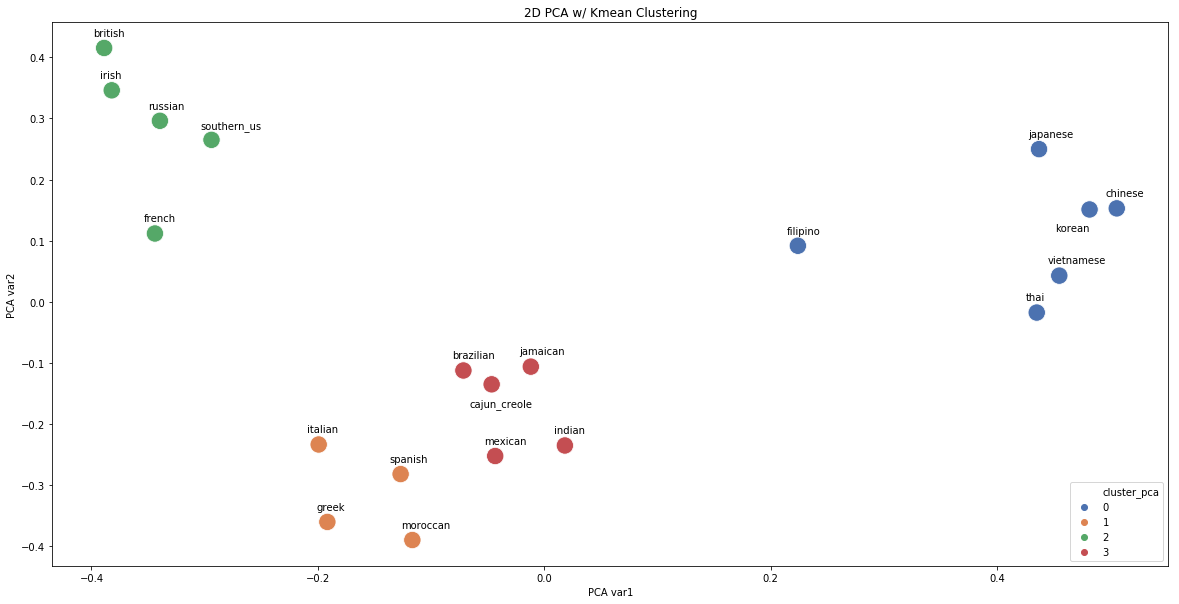

In [32]:
plt.figure(1)
plt.clf()
#cpal = sns.color_palette('icefire',4)
cpal = sns.color_palette('deep',4)
sns.scatterplot(data=plotX,x='PC1_2d',y='PC2_2d',hue='cluster_pca',s=300,legend='full',palette=cpal)
#plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.legend(loc="lower right")
for ii, cc in enumerate(acus):
    if (cc=='cajun_creole'):
        plt.annotate(cc, (pca1_2d[ii]-0.02, pca2_2d[ii]-0.035) )
    elif (cc=='korean'):
        plt.annotate(cc, (pca1_2d[ii]-0.03, pca2_2d[ii]-0.035) )
    else:
        plt.annotate(cc, (pca1_2d[ii]-0.01, pca2_2d[ii]+0.02) )
plt.xlabel('PCA var1')
plt.ylabel('PCA var2')
plt.title('2D PCA w/ Kmean Clustering')
plt.rcParams["figure.figsize"] = (20,10)

The above plot shows the 20 different types of cuisine in labeled in the data set. I have done a principle component analysis (PCA) to reduce the dimensionality of the term frequency inverse document frequency (TFIDF) matrix. This score matrix describes how many times a word is used in the compiled recipes (term frequency) for each cuisine and is penalized for being used in multiple types of cuisines (inverse document frequency).

In this dimension reduction, the data has gone from 2706 dimensions to 2 dimesions. There is obviously some redundency of information in the large dimensionality which makes the PCA possible. I have also done a Kmeans clustering analysis of the 20 different types of cuisine. They have been grouped into 4 clusters which match my intuition one what foods are similiar and which types of foods are different.

Text(159.0, 0.5, 'Cusine Ingredient Vector B')

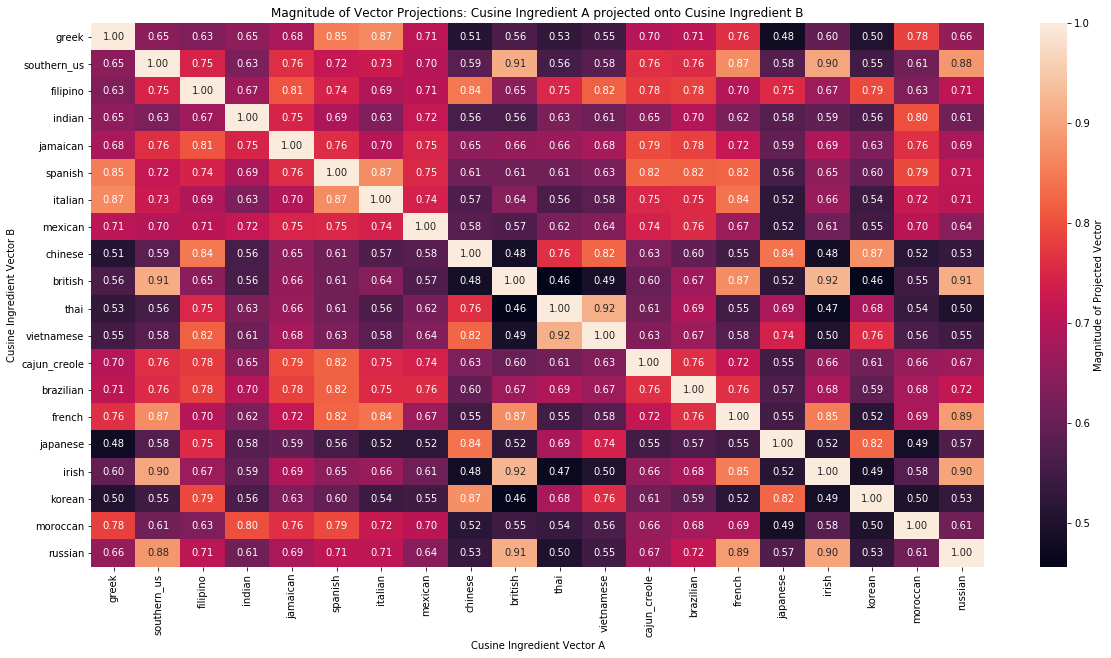

In [35]:
## vector projections proj a onto b
nrow = X_ar.shape[0] #20
ncol = X_ar.shape[1] #2706
vect_proj = np.zeros([nrow,nrow,ncol])
for jj in np.arange(0,nrow):
    a = X_ar[jj,:]
    for ii in np.arange(0,nrow):
        b = X_ar[ii,:]
        vect_proj[jj,ii,:] = (np.vdot(a,b)/np.vdot(b,b))*b

vect_mag = np.sqrt((vect_proj**2).sum(axis=2))
plt.figure(2)
plt.clf()
sns.heatmap(vect_mag,annot=True, fmt=".2f",cbar_kws={'label': 'Magnitude of Projected Vector'})
plt.yticks(np.arange(0.5,20.5),acus,rotation=0);
plt.xticks(np.arange(0.5,20.5),acus,rotation=90);
plt.title('Magnitude of Vector Projections: Cusine Ingredient A projected onto Cusine Ingredient B')
plt.xlabel('Cusine Ingredient Vector A')
plt.ylabel('Cusine Ingredient Vector B')

The above plot shows the a heatmap of the magnitude of the vector projections. In this calculation, I have taken the ingredient vector of a cuisine and then projected that onto the ingredient vector of a different type of cuisine. After taking the projection, I calculated the magnitude of the vector. This plot essentially tells how similiar two types of cuisines are based on their ingredients with a value of 1 being exact and a value of 0 being completely orthogonal.